In [1]:
#!/usr/bin/python

# Importing necessary libraries
import sys
import math
import random
import time
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Function to generate random 0-1 rewards corresponding to an arm a
def generate_rewards(arm):
    global p
    if (random.uniform(0, 1.0) < p[arm]):
        return 1
    else:
        return 0

def epsilon_greedy(epsilon, n_arms, horizon, max_reward):
    rewards = [0 for _ in range(n_arms)]
    pulls_count = [0 for _ in range(n_arms)]
    emp_mean = [0 for _ in range(n_arms)]
    a = 0
    for _ in range(horizon):
        x = random.uniform(0,1.0)
        if (x < epsilon):
            a = random.randint(0,n_arms-1)
        else:
            a = np.argmax(emp_mean)
        r = generate_rewards(a)
        rewards[a] += r
        pulls_count[a] += 1
        emp_mean[a] = (rewards[a]/pulls_count[a])
    # print(emp_mean)
    return (max_reward - sum(rewards))

def UCB(horizon, max_reward, n_arms):
    ucb_val = [0 for _ in range(n_arms)]
    rewards = [0 for _ in range(n_arms)]
    emp_mean = [0 for _ in range(n_arms)]
    pulls_count = [0 for _ in range(n_arms)]
    for t in range(min(n_arms,horizon)):
        r = generate_rewards(t)
        rewards[t] = r
        pulls_count[t] = 1
        emp_mean[t] = r
    for t in range(n_arms,horizon):
        for i in range(n_arms):
            ucb_val[i] = emp_mean[i] + math.sqrt((2*(math.log(t)))/pulls_count[i])
        a = np.argmax(ucb_val)
        r = generate_rewards(a)
        rewards[a] += r
        pulls_count[a] += 1
        emp_mean[a] = (rewards[a]/pulls_count[a])
    # print(emp_mean)
    return (max_reward - sum(rewards))

def KL_UCB(horizon, max_reward, n_arms, c):
    kl_ucb_val = [0 for _ in range(n_arms)]
    rewards = [0 for _ in range(n_arms)]
    emp_mean = [0 for _ in range(n_arms)]
    pulls_count = [0 for _ in range(n_arms)]
    for t in range(min(n_arms,horizon)):
        r = generate_rewards(t)
        rewards[t] = r
        pulls_count[t] = 1
        emp_mean[t] = r
    for t in range(n_arms,horizon):
        val = math.log(t)+(c*(math.log(math.log(t))))
        precision = 1e-6
        for i in range(n_arms):
            l = emp_mean[i]
            r = 1
            while (r-l) > precision:
                mid = (l+r)/2
                if emp_mean[i] == 0:
                    kl = ((1-emp_mean[i])*(math.log((1-emp_mean[i])/(1-mid))))
                elif emp_mean[i] == 1:
                    kl = ((emp_mean[i])*(math.log(emp_mean[i]/mid)))
                else:                        
                    kl = ((emp_mean[i])*(math.log(emp_mean[i]/mid)))+((1-emp_mean[i])*(math.log((1-emp_mean[i])/(1-mid))))
                if (pulls_count[i]*kl) <= val:
                    l = mid
                else:
                    r = mid
            kl_ucb_val[i] = l
        a = np.argmax(kl_ucb_val)
        r = generate_rewards(a)
        rewards[a] += r
        pulls_count[a] += 1
        emp_mean[a] = (rewards[a]/pulls_count[a])
    # print(emp_mean)
    return (max_reward - sum(rewards))

def thompson_sampling(horizon, max_reward, n_arms):
    s = [0 for _ in range(n_arms)]
    rewards = [0 for _ in range(n_arms)]
    emp_mean = [0 for _ in range(n_arms)]
    pulls_count = [0 for _ in range(n_arms)]
    for _ in range(horizon):
        x = []
        for i in range(n_arms):
            x.append(random.betavariate(s[i]+1,pulls_count[i]-s[i]+1))
        a = np.argmax(x)
        r = generate_rewards(a)
        rewards[a] += r
        if r == 1:
            s[a] += 1
        pulls_count[a] += 1
        emp_mean[a] = (rewards[a]/pulls_count[a])
    # print(emp_mean)
    return (max_reward - sum(rewards))

def thompson_sampling_with_hint(horizon, max_reward, n_arms, hint_ts):
    belief = [[1/(n_arms) for _ in range(n_arms)] for _ in range(n_arms)]
    rewards = [0 for _ in range(n_arms)]
    emp_mean = [0 for _ in range(n_arms)]
    pulls_count = [0 for _ in range(n_arms)]
    for t in range(horizon):
        x = []
        for i in range(n_arms):
            x.append(belief[i][-1])
        a = np.argmax(x)
        r = generate_rewards(a)
        if r == 1:
            for i in range(n_arms):
                belief[a][i] = (belief[a][i]*hint_ts[i])/(np.dot(belief[a],hint_ts))
        else:
            for i in range(n_arms):
                belief[a][i] = (belief[a][i]*(1-hint_ts[i]))/(np.dot(belief[a],1-hint_ts))
        rewards[a] += r
        pulls_count[a] += 1
        emp_mean[a] = (rewards[a]/pulls_count[a])
    return (max_reward - sum(rewards))

In [ ]:
h = [[] for _ in range(3)]
ts = [[] for _ in range(3)]
e = [[0.4,0.8],[0.4,0.3,0.5,0.2,0.1],[0.15,0.23,0.37,0.44,0.50,0.32,0.78,0.21,0.82,0.56,0.34,0.56,0.84,0.76,0.43,0.65,0.73,0.92,0.10,0.89,0.48,0.96,0.60,0.54,0.49]]
for i in tqdm(range(3)):
  p = e[i]
  n_arms = len(p)
  hint_ts = np.sort(p)
  for t in tqdm((100,400,1600,6400,25600,102400)):
    a = []
    b = []
    horizon = t
    max_reward = horizon*(max(p))
    for s in range(50): 
      random.seed(s)
      a.append(thompson_sampling_with_hint(horizon, max_reward, n_arms, hint_ts))
      b.append(thompson_sampling(horizon, max_reward, n_arms))
    h[i].append(np.mean(a))
    ts[i].append(np.mean(b))

100%|██████████| 3/3 [37:03<00:00, 741.14s/it]


In [ ]:
eg = [[] for _ in range(3)]
ucb = [[] for _ in range(3)]
kl_ucb = [[] for _ in range(3)]
th_sa = [[] for _ in range(3)]
e = [[0.4,0.8],[0.4,0.3,0.5,0.2,0.1],[0.15,0.23,0.37,0.44,0.50,0.32,0.78,0.21,0.82,0.56,0.34,0.56,0.84,0.76,0.43,0.65,0.73,0.92,0.10,0.89,0.48,0.96,0.60,0.54,0.49]]
for i in tqdm(range(3)):
  p = e[i]
  n_arms = len(p)
  for t in tqdm((100,400,1600,6400,25600,102400)):
    a = []
    b = []
    c = []
    d = []
    horizon = t
    max_reward = horizon*(max(p))
    for s in range(50): 
      random.seed(s)
      a.append(epsilon_greedy(0.02, n_arms, horizon, max_reward))
      b.append(UCB(horizon, max_reward, n_arms))
      c.append(KL_UCB(horizon, max_reward, n_arms, 3))
      d.append(thompson_sampling(horizon, max_reward, n_arms))
    eg[i].append(np.mean(a))
    ucb[i].append(np.mean(b))
    kl_ucb[i].append(np.mean(c))
    th_sa[i].append(np.mean(d))

100%|██████████| 3/3 [1:16:59<00:00, 1539.90s/it]


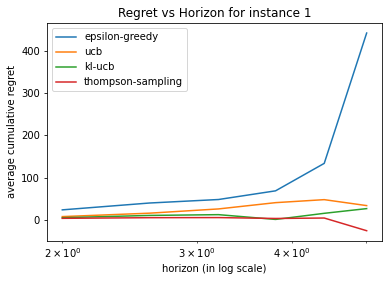

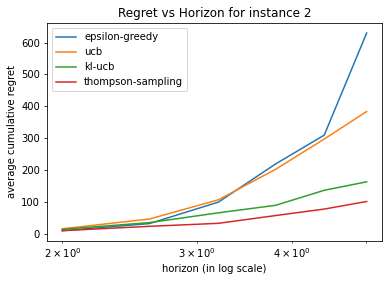

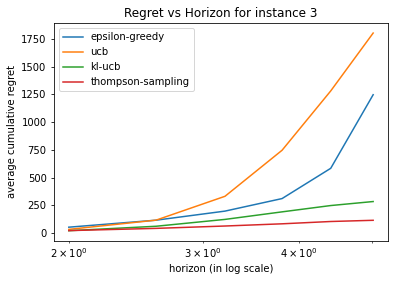

In [ ]:
horizons = np.log10([100,400,1600,6400,25600,102400])
for i in range(1,4):
  plt.plot(horizons, eg[i-1], label = "epsilon-greedy")
  plt.plot(horizons, ucb[i-1], label = "ucb")
  plt.plot(horizons, kl_ucb[i-1], label = "kl-ucb")
  plt.plot(horizons, th_sa[i-1], label = "thompson-sampling")

  plt.xscale("log")
  plt.xlabel('horizon (in log scale)')
  plt.ylabel('average cumulative regret')
  plt.title('Regret vs Horizon for instance {}'.format(i))
  plt.legend()
  plt.savefig(str(i)+'_T1')
  plt.show()

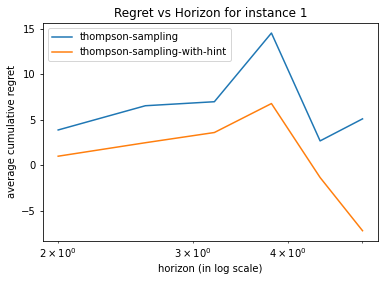

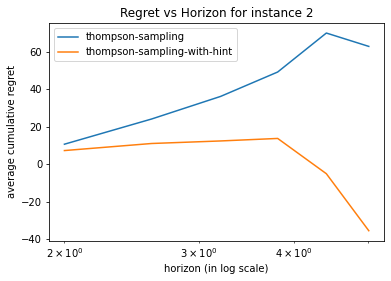

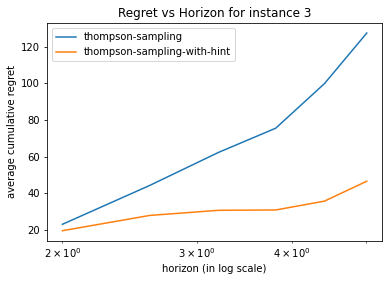

In [ ]:
horizons = np.log10([100,400,1600,6400,25600,102400])
for i in range(1,4):
  plt.plot(horizons, ts[i-1], label = "thompson-sampling")
  plt.plot(horizons, h[i-1], label = "thompson-sampling-with-hint")

  plt.xscale("log")
  plt.xlabel('horizon (in log scale)')
  plt.ylabel('average cumulative regret')
  plt.title('Regret vs Horizon for instance {}'.format(i))
  plt.legend()
  plt.savefig(str(i)+'_T2')
  plt.show()

In [ ]:
import os,random,subprocess
eg1 = [[] for _ in range(3)]
ucb1 = [[] for _ in range(3)]
kl_ucb1 = [[] for _ in range(3)]
th_sa1 = [[] for _ in range(3)]
f = open("outputDataT1.txt", "r")
line_ls = [line for line in f.read().split("\n")]
n = 0
for i in range(3):
  for k in range(6):
    s = 0
    for x in range(50):
      s += float(line_ls[n].replace("\n","").split(",")[-1])
      n += 1
    eg1[i].append(s/50)
  for k in range(6):
    s = 0
    for x in range(50):
      s += float(line_ls[n].replace("\n","").split(",")[-1])
      n += 1
    ucb1[i].append(s/50)
  for k in range(6):
    s = 0
    for x in range(50):
      s += float(line_ls[n].replace("\n","").split(",")[-1])
      n += 1
    kl_ucb1[i].append(s/50)
  for k in range(6):
    s = 0
    for x in range(50):
      s += float(line_ls[n].replace("\n","").split(",")[-1])
      n += 1
    th_sa1[i].append(s/50)

In [ ]:
print(eg)
print(eg1)
print(ucb)
print(ucb1)
print(kl_ucb)
print(kl_ucb1)
print(th_sa)
print(th_sa1)

[[23.5, 39.74, 48.04, 68.62, 133.76, 442.84], [9.02, 31.5, 98.98, 218.58, 309.18, 629.8], [53.96, 117.02, 198.78, 311.74, 584.42, 1247.26]]
[[23.5, 39.74, 48.04, 68.62, 133.76, 442.84], [9.02, 31.5, 98.98, 218.58, 309.18, 629.8], [53.96, 117.02, 198.78, 311.74, 584.42, 1247.26]]
[[7.52, 15.64, 25.7, 40.6, 47.72, 33.6], [15.04, 45.82, 106.28, 201.86, 296.84, 383.4], [34.3, 117.28, 332.28, 746.92, 1281.5, 1802.92]]
[[6.82, 15.8, 26.32, 39.32, 41.16, 44.94], [14.3, 42.96, 102.48, 195.6, 272.74, 344.2], [33.96, 118.08, 332.66, 740.24, 1276.24, 1816.92]]
[[4.88, 10.3, 12.14, 0.82, 15.3, 26.46], [13.44, 34.48, 65.26, 88.8, 135.96, 162.66], [22.16, 62.36, 124.04, 192.04, 248.92, 285.02]]
[[3.52, 8.38, 12.46, 19.08, 13.68, 10.04], [11.94, 31.4, 63.88, 99.38, 115.66, 114.94], [21.64, 62.28, 126.8, 189.52, 245.18, 300.2]]
[[3.4, 4.94, 5.18, 3.08, 4.14, -25.96], [9.12, 22.82, 32.24, 56.64, 77.0, 100.76], [23.2, 43.26, 64.52, 84.36, 105.2, 116.0]]
[[3.1, 4.98, 9.28, 15.98, 5.14, -1.08], [10.94, 24

In [ ]:
import os,random,subprocess
h1 = [[] for _ in range(3)]
ts1 = [[] for _ in range(3)]
f = open("outputDataT2.txt", "r")
line_ls1 = [line for line in f.read().split("\n")]
m = 0
for i in range(3):
  for k in range(6):
    s = 0
    for x in range(50):
      s += float(line_ls1[m].replace("\n","").split(",")[-1])
      m += 1
    ts1[i].append(s/50)
  for k in range(6):
    s = 0
    for x in range(50):
      s += float(line_ls1[m].replace("\n","").split(",")[-1])
      m += 1
    h1[i].append(s/50)

In [ ]:
print(h)
print(h1)
print(ts)
print(ts1)

[[1.0, 2.48, 3.6, 6.78, -1.34, -7.18], [7.32, 11.1, 12.46, 13.8, -5.06, -35.54], [19.7, 28.02, 30.82, 31.0, 35.8, 46.66]]
[[1.0, 2.48, 3.6, 6.78, -1.34, -7.18], [7.32, 11.1, 12.46, 13.8, -5.06, -35.54], [19.7, 28.02, 30.82, 31.0, 35.8, 46.66]]
[[3.88, 6.54, 6.98, 14.52, 2.68, 5.1], [10.72, 24.2, 36.28, 49.32, 70.16, 63.02], [23.2, 44.34, 62.38, 75.52, 99.76, 127.36]]
[[3.1, 4.98, 9.28, 15.98, 5.14, -1.08], [10.94, 24.64, 37.78, 48.9, 66.82, 94.36], [22.82, 44.16, 65.24, 84.92, 108.18, 127.86]]


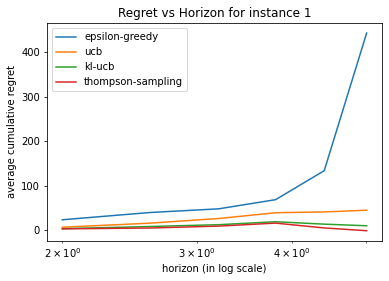

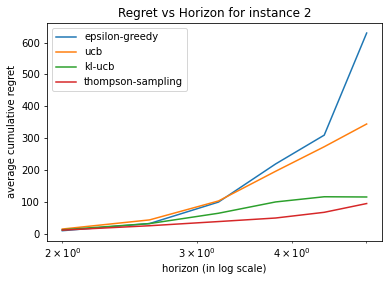

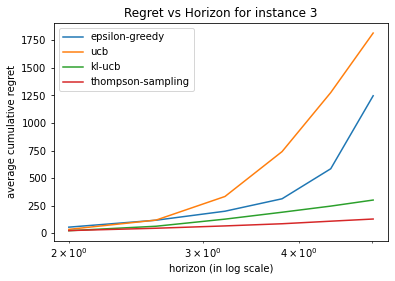

In [ ]:
horizons = np.log10([100,400,1600,6400,25600,102400])
for i in range(1,4):
  plt.plot(horizons, eg1[i-1], label = "epsilon-greedy")
  plt.plot(horizons, ucb1[i-1], label = "ucb")
  plt.plot(horizons, kl_ucb1[i-1], label = "kl-ucb")
  plt.plot(horizons, th_sa1[i-1], label = "thompson-sampling")

  plt.xscale("log")
  plt.xlabel('horizon (in log scale)')
  plt.ylabel('average cumulative regret')
  plt.title('Regret vs Horizon for instance {}'.format(i))
  plt.legend()
  plt.savefig(str(i)+'_T1')
  plt.show()

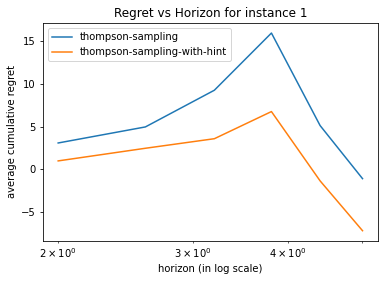

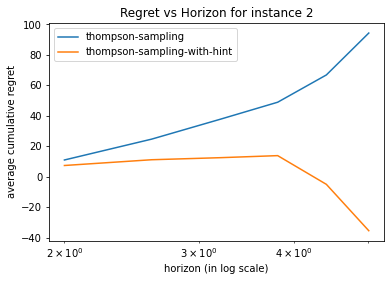

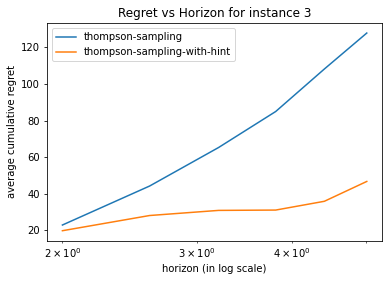

In [ ]:
horizons = np.log10([100,400,1600,6400,25600,102400])
for i in range(1,4):
  plt.plot(horizons, ts1[i-1], label = "thompson-sampling")
  plt.plot(horizons, h1[i-1], label = "thompson-sampling-with-hint")

  plt.xscale("log")
  plt.xlabel('horizon (in log scale)')
  plt.ylabel('average cumulative regret')
  plt.title('Regret vs Horizon for instance {}'.format(i))
  plt.legend()
  plt.savefig(str(i)+'_T2')
  plt.show()

In [5]:
e = [[0.4,0.8],[0.4,0.3,0.5,0.2,0.1],[0.15,0.23,0.37,0.44,0.50,0.32,0.78,0.21,0.82,0.56,0.34,0.56,0.84,0.76,0.43,0.65,0.73,0.92,0.10,0.89,0.48,0.96,0.60,0.54,0.49]]
reg_values = [[] for _ in range(3)]
for i in tqdm(range(3)):
  p = e[i]
  n_arms = len(p)
  max_reward = 102400*max(p)
  for epsilon in tqdm((0.001,0.02,0.1,0.4,0.9,1)):
    s = 0
    for seed in range(50):
      random.seed(seed)
      s += epsilon_greedy(epsilon, n_arms, 102400, max_reward)
    reg_values[i].append(s/50)
print(reg_values)



  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/6 [00:00<?, ?it/s]


 17%|█▋        | 1/6 [00:29<02:27, 29.56s/it]


 33%|███▎      | 2/6 [00:59<01:58, 29.54s/it]


 50%|█████     | 3/6 [01:27<01:27, 29.22s/it]


 67%|██████▋   | 4/6 [01:50<00:54, 27.38s/it]


 83%|████████▎ | 5/6 [02:03<00:23, 23.08s/it]


100%|██████████| 6/6 [02:14<00:00, 22.42s/it]


 33%|███▎      | 1/3 [02:14<04:29, 134.52s/it]


  0%|          | 0/6 [00:00<?, ?it/s]


 17%|█▋        | 1/6 [00:31<02:35, 31.08s/it]


 33%|███▎      | 2/6 [01:01<02:03, 30.87s/it]


 50%|█████     | 3/6 [01:30<01:30, 30.29s/it]


 67%|██████▋   | 4/6 [01:53<00:56, 28.12s/it]


 83%|████████▎ | 5/6 [02:06<00:23, 23.52s/it]


100%|██████████| 6/6 [02:16<00:00, 22.82s/it]


 67%|██████▋   | 2/3 [04:31<02:15, 135.24s/it]


  0%|          | 0/6 [00:00<?, ?it/s]


 17%|█▋        | 1/6 [00:39<03:15, 39.13s/it]


 33%|███▎      | 2/6 [01:14<02:31, 37.89s/it]


 50%|█████     | 3/6 [01:47<01:49, 36.46s/it]


 67%|██████▋   | 4/6

[[1279.46, 442.84, 2042.28, 8183.12, 18417.4, 20477.76], [2579.0, 629.8, 2076.52, 8192.28, 18429.8, 20505.9], [6005.78, 1247.26, 4356.94, 16941.78, 38094.84, 42308.5]]
